<h1 style="text-align:center; font-weight:bold;">
Projet d’Optimisation et de Machine Learning
</h1>

<p style="text-align:center; font-weight:bold;">
Jana Taleb et Dima Hajj Ali
</p>

<p style="text-align:center; font-style:italic;">
Octobre-December 2025
</p>

## 1. Objectif

L’objectif de ce projet est de prédire le placement des étudiants à partir de leurs
caractéristiques académiques et professionnelles en utilisant un modèle de
régression logistique défini par :

$$
\hat{b}_i = \mathrm{sign}(x^\top y_i),
$$

où $b_i \in \{-1,+1\}$ désigne l’étiquette de placement du $i$-ème étudiant
($b_i = +1$ si l’étudiant est placé et $b_i = -1$ sinon),
$x \in \mathbb{R}^d$ est le vecteur de paramètres du modèle à estimer,
et $y_i \in \mathbb{R}^d$ représente le vecteur des caractéristiques du $i$-ème étudiant.

L’objectif revient alors à résoudre le problème d’optimisation suivant,
correspondant à une régression logistique régularisée par une pénalisation
Elastic Net:
$$
\hat{x} \in \arg\min_{x \in \mathbb{R}^d}
\frac{1}{N}\sum_{i=1}^{N}
\log\left(1+\exp\left(-b_i x^\top y_i\right)\right)
+ \lambda\left(\alpha \|x\|_1 + \frac{1-\alpha}{2}\|x\|_2^2\right),
$$

où $N$ représente le nombre total d’étudiants dans l’ensemble d’apprentissage,
$\lambda > 0$ est le paramètre de régularisation,
et $\alpha \in [0,1]$ contrôle le compromis entre la pénalisation $\ell_1$
et la pénalisation $\ell_2$.

La fonction de coût ci-dessus est minimisée afin d’obtenir les valeurs optimales
des paramètres du modèle.

## 2. Base de données
Les données utilisées dans ce projet proviennent du fichier
**`CollegePlacement.csv`**, qui est chargé localement dans notre notebook.
    
Ce jeu de données contient des informations académiques et professionnelles sur les étudiants, telles que les résultats scolaires, les compétences, ainsi que d’autres caractéristiques pertinentes.

Ces données sont utilisées pour l’entraînement et l’évaluation du modèle de régression logistique présenté dans la section précédente, dont l’objectif est de prédire le placement des étudiants.

Le jeu de données initial contient des informations concernant 10000 étudiants (N = 10000). Cependant, l’utilisation de l’ensemble complet des données entraîne un temps de calcul élevé, en particulier lors de l’application d’algorithmes d’optimisation itératifs, qui nécessitent un grand nombre d’itérations pour converger.

Afin de réduire la complexité computationnelle et de faciliter l’analyse expérimentale, les choix suivants ont été adoptés :

- Un **sous-ensemble de 200 étudiants** a été sélectionné aléatoirement parmi les 10000 disponibles.
- La variable **college_id** a été exclue du jeu de données.

Ces choix permettent de réduire significativement le temps de calcul tout en conservant un jeu de données représentatif du problème étudié.



Avant de présenter les méthodes d’optimisation utilisées pour résoudre le
problème de minimisation, nous introduisons les bibliothèques Python employées
dans ce travail. Celles-ci permettent de gérer, de prétraiter et d’analyser les
données.

Les principales bibliothèques utilisées sont les suivantes :


In [113]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import cross_val_score 
from tqdm import tqdm 

Les données sont lues à partir du fichier `CollegePlacement.csv` à l’aide de la
commande `pd.read_csv`. Afin de réduire le temps de calcul, nous avons choisi de
ne charger que les 200 premières lignes du jeu de données.

In [114]:
df=pd.read_csv('CollegePlacement.csv',nrows=200) 

La commande `df.head(3)` permet d’afficher un exemple des trois premières lignes
du jeu de données, afin d’avoir un aperçu rapide de la structure et des variables
contenues dans les données.


In [115]:
df.head(3)

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No


À partir du jeu de données, nous construisons ensuite les variables utilisées dans
le modèle de régression logistique.

La variable cible $b$ correspond à la colonne **Placement**, qui est transformée
en labels numériques, avec $+1$ pour *Yes* et $-1$ pour *No*.

Les variables explicatives $y$ sont obtenues en supprimant la colonne cible
**Placement** ainsi que l’identifiant **College_ID**, qui ne contient pas
d’information pertinente pour la prédiction.

Les variables catégorielles restantes sont transformées en variables numériques
à l’aide d'un commande (`get_dummies`).

On obtient ainsi une matrice de données $y \in \mathbb{R}^{N \times d}$, où
$N = 200$ représente le nombre d’observations et $d = 8$ le nombre de variables
explicatives.

Le code suivant présente l’implémentation des étapes de construction des variables
$b$ et $y$ à partir du jeu de données.

In [116]:
b=df['Placement']
b = np.where(b == 'Yes', 1.0, -1.0) 
y = df.drop('Placement', axis=1)
y=y.drop('College_ID',axis=1)
y = pd.get_dummies(y, drop_first=True)
y=np.array(y)

N, d = y.shape
print('N=',N)
print('d=',d)

N= 200
d= 8


## 3. Méthodes d’optimisation

Afin d’atteindre l’objectif de ce projet et de résoudre le problème
d’optimisation associé au modèle de régression logistique régularisé
par la pénalisation Elastic Net, nous avons choisi d’utiliser plusieurs
algorithmes d’optimisation.

Plus précisément, trois approches ont été considérées :

- **FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)**

- **L’algorithme de Chambolle–Pock** 

- **L’algorithme ADAM (Alternating Direction Method of Multipliers)** :
  utilisé via l’implémentation proposée par la bibliothèque *PyTorch*.

Dans la suite, nous présentons le principe de chacun de ces algorithmes en
l’appliquant à notre problème d’optimisation.
Pour chaque algorithme, nous implémentons la méthode, analysons l’évolution
de la fonction de coût ainsi que de la norme $\|x_k - \hat{x}\|_2$ en fonction
du nombre d’itérations, et étudions l’influence des différents paramètres.
Enfin, une comparaison des trois algorithmes est réalisée en se plaçant sur
les paramètres optimaux.


### 3.1 Algorithme FISTA

Nous considérons un problème composé de la forme

$$
\min_{x \in \mathbb{R}^d} F(x) = f(x) + g(x),
$$
où  $f,g$ appartienent à $\Gamma_0(\mathbb{R}^d)$ , et $f$ est différentiable à gradient Lipschitzien.

Dans notre problème, nous avons testé l’algorithme FISTA avec deux choix des
fonctions $f$ et $g$:

- **Premier choix :**  
  La fonction $f$ correspond à la fonction de perte logistique à laquelle
  nous ajoutons un terme de pénalisation Elastic Net, plus précisément la partie
  associée à la norme $\ell_2$. Elle est définie comme suit :
  $$
  f(x) = \frac{1}{N}\sum_{i=1}^{N}
  \log\left(1+\exp\left(-b_i x^\top y_i\right)\right)
  + \frac{\lambda(1-\alpha)}{2}\|x\|_2^2.
  $$

  La fonction $g$ correspond au terme de pénalisation Elastic Net associé à
  la norme $\ell_1$. Elle est définie comme suit :
  $$
  g(x) = \lambda \alpha \|x\|_1.
  $$

- **Deuxième choix :**  
  La fonction $f$ correspond uniquement à la fonction de perte logistique,
  sans ajout de terme de pénalisation. Elle est définie comme suit :
  $$
  f(x) = \frac{1}{N}\sum_{i=1}^{N}
  \log\left(1+\exp\left(-b_i x^\top y_i\right)\right).
  $$

  La fonction $g$ correspond au terme de pénalisation Elastic Net. Elle est définie comme suit :
  $$
  g(x) = \lambda\left(\alpha \|x\|_1 + \frac{1-\alpha}{2}\|x\|_2^2\right).
  $$

**Remarque :**  
Ces deux choix peuvent être considérés, puisque dans les deux cas, les fonctions $f$ et $g$ satisfont les propriétés requises par l’algorithme FISTA. La démonstration de ces propriétés sera présentée dans la suite du rapport.

**Schéma numérique de FISTA :**

- Initialiser $x_0$, poser $x_0 = z_0$ et $t_0 = 1$.
- Pour tout $k \in \mathbb{N}$ :

$$
x_{k+1}=\mathrm{prox}_{\gamma g}\!\left(z_k-\gamma \nabla f(z_k)\right),
$$

$$
t_{k+1}=\frac{1+\sqrt{1+4t_k^2}}{2},
\qquad
\lambda_k=\frac{t_k-1}{t_{k+1}},
$$

$$
z_{k+1}=x_{k+1}+\lambda_k\left(x_{k+1}-x_k\right).
$$

où $\gamma > 0$ est choisi tel que $0 < \gamma < 1/ \beta$, avec $\beta$ la constante de Lipschitz du gradient de $f$.

- Répéter jusqu’à satisfaction du critère d’arrêt.


Nous commençons maintenant par l’étude détaillée du premier choix.

### 3.1.1 Étude du premier choix 

Nous considérons dans cette section le premier choix de la fonction $f$:
$$
f(x) = \frac{1}{N}\sum_{i=1}^{N}
\log\left(1+\exp\left(-b_i x^\top y_i\right)\right)
+ \frac{\lambda(1-\alpha)}{2}\|x\|_2^2.
$$

Afin de simplifier les notations lors de la démonstration de la différentiabilité
de $f$ et du calcul de son gradient, nous
notons par $h(x)$ la partie correspondant à la perte logistique, et par
$q(x)$ la partie correspondant au terme de pénalisation Elastic Net associé
à la norme $\ell_2$.

 
### $f$ appartienent à $\Gamma_0(\mathbb{R}^d)$)

On considère
$$
f(x)=h(x)+q(x).
$$
Avec
$$
h(x)=\frac{1}{N}\sum_{i=1}^{N}\log\left(1+\exp\left(-b_i x^\top y_i\right)\right),
\qquad
q(x)=\frac{\lambda(1-\alpha)}{2}\|x\|_2^2,
$$

#### 1) Convexité de $h$ 

Soit $s:\mathbb{R}\to\mathbb{R}$ définie par $s(t)=\log(1+\exp(t))$, alors sa dérivée est donnée par
$$
s'(t)=\frac{\exp(t)}{1+\exp(t)}.
$$
Donc
$$
s''(t)=\frac{\exp(t)}{\left(1+\exp(t)\right)^2} \geq 0.
$$
Alors, $s$ est convexe sur $\mathbb{R}$.
    
De plus, pour tout $i$, la fonction $x\mapsto -b_i x^\top y_i$ est affine ; par
composition d’une fonction convexe avec une application affine, on en déduit que
$$
s(-b_i x^\top y_i)=\log\left(1+\exp\left(-b_i x^\top y_i\right)\right)
$$
est convexe. La somme de fonctions convexes est convexe, et sa multiplication par une constante
positive (ici $1/N$) préserve la convexité.
Par conséquent, la fonction $h$ est convexe.


#### 2) Convexité de $q$
On considère la fonction
$$
r(x) = \|x\|_2^2 = x^\top x, \quad x \in \mathbb{R}^d.
$$
    
Et, le gradient de $r$ est donné par :
$$
\nabla r(x) = 2x.
$$

Donc, le hessien de $r$ vaut :
$$
\nabla^2 r(x) = 2 I_d,
$$
où $I_d$ désigne la matrice identité de dimension $d$.

La matrice $2 I_d$ est symétrique définie positive. Par conséquent, la fonction
$$
x \mapsto \|x\|_2^2
$$
est convexe sur $\mathbb{R}^d$ et, comme
$\frac{\lambda(1-\alpha)}{2}\ge 0$, il s’ensuit que $q$ est convexe.

#### 3) Propreté et semi-continuité inférieure

En prenant $x=0$, on obtient
$$
h(0)=\log(2) \quad \text{et} \quad q(0)=0,
$$
d’où $f(0)=\log(2) < +\infty$.

alors, il $\exists\, x \in \mathbb{R}^d$ tel que $f(x) < +\infty$, donc $\operatorname{dom}(f) \neq \varnothing$.

Donc, la fonction $f$ est propre.

De plus, $h$ et $q$ sont continues sur $\mathbb{R}^d$ (composition et somme de
fonctions continues), donc elles sont semi-continues inférieurement.
La somme de fonctions semi-continues inférieurement étant semi-continue
inférieurement, on conclut que $f$ est semi-continue inférieurement.

#### Conclusion

La fonction $f$ est convexe, propre et semi-continue inférieurement sur
$\mathbb{R}^d$. Alors, $f$ appartient à $\Gamma_0(\mathbb{R}^d)$.

### La différentiabilité de $f$ :

#### 1) La différentiabilité de $h(x)$

Pour $i \in \{1,\ldots,N\}$, posons
$$
\varphi_i(x)=\log\left(1+\exp\left(-b_i x^\top y_i\right)\right).
$$
On décompose $\varphi_i$ comme une composition de fonctions :
- $u_i(x)= -b_i x^\top y_i$. La fonction $x \mapsto x^\top y_i$ est linéaire,
donc $u_i$ est différentiable sur $\mathbb{R}^d$.
- $v(t)=\exp(t)$ est différentiable sur $\mathbb{R}$.
- $w(s)=\log(s)$ est différentiable sur $]0,+\infty[$.

Comme $v(t) \ge 0$ pour tout $t\in\mathbb{R}$, donc $w(v(t))$
est bien définie. Par composition de fonctions différentiables, $\varphi_i$ est
différentiable sur $\mathbb{R}^d$.

Enfin, la somme finie de fonctions différentiables étant différentiable, la fonction
$$
h(x)=\frac{1}{N}\sum_{i=1}^{N}\varphi_i(x)
$$
est différentiable sur $\mathbb{R}^d$.

#### 2) La Différentiabilité de $q(x)$:

On considère
$$
q(x)=\frac{\lambda(1-\alpha)}{2}\|x\|_2^2.
$$
Or $\|x\|_2^2=x^\top x$ est un polynôme en les composantes de $x$, donc une
fonction différentiable sur $\mathbb{R}^d$. La multiplication par la constante
$\frac{\lambda(1-\alpha)}{2}$ conserve la différentiabilité, donc $q$ est
différentiable sur $\mathbb{R}^d$.

#### Conclusion

Comme $f(x)=h(x)+q(x)$ et que $h$ et $q$ sont différentiables sur $\mathbb{R}^d$,
on en déduit que $f$ est différentiable sur $\mathbb{R}^d$.


### Le gradient de $f$ :
Le gradient de la fonction $f$ s’écrit comme la somme des gradients de
ses deux composantes :
$$
\nabla f(x) = \nabla h(x) + \nabla q(x).
$$

Concernant $h(x)$, on a :
$$
h(x) = \frac{1}{N}\sum_{i=1}^{N}
\log\left(1+\exp\left(-b_i x^\top y_i\right)\right).
$$

Pour calculer le gradient de $h$, il est nécessaire de dériver chaque terme
de la somme par rapport à $x$ .Alors, pour tout
$i \in \{1,\ldots,N\}$, on pose :
$$
\varphi_i(x) = \log\left(1+\exp\left(-b_i x^\top y_i\right)\right).
$$
####  Gradient de $\varphi_i$:

Posons
$$
u_i(x)=-b_i x^\top y_i.
$$
Alors $\varphi_i(x)=\log(1+\exp(u_i(x)))$.

On dérive par la règle de la chaîne :
- $u_i$ est linéaire, donc $\nabla u_i(x)=-b_i y_i$ ;
- pour $s\in\mathbb{R}$, la dérivée de $\log(1+\exp(s))$ vaut
$$
\frac{d}{ds}\log(1+\exp(s))=\frac{\exp(s)}{1+\exp(s)}=:\sigma(s),
$$

Donc
$$
\nabla \varphi_i(x)=\sigma(u_i(x))\,\nabla u_i(x)=\sigma(-b_i x^\top y_i)\,(-b_i y_i).
$$
On obtient :
$$
\nabla \varphi_i(x)
= -b_i y_i \,
\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}.
$$
Donc
$$
\nabla h(x)=\frac{1}{N}\sum_{i=1}^{N}
-b_i y_i \,
\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}.
$$

En écrivant composante par composante ($y_{i,j}$ désigne la $j$-ème
composante de $y_i$), pour tout $j = 1,\dots,d$, on a :
$$
\big(\nabla h(x)\big)_j=\frac{1}{N}\sum_{i=1}^{N}
-b_i y_{i,j}\,
\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}.
$$

On obtient alors:
$$
\nabla h(x)=\frac{1}{N}\,y^\top
\left(
-b_i\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}
\right)_{1\le i\le N}.
$$

Et concernant $q(x)$, on a:
$$
q(x)=\frac{\lambda(1-\alpha)}{2}\|x\|_2^2.
$$
Comme $\|x\|_2^2 = x^\top x$, on obtient :
$$
\nabla q(x)=\lambda(1-\alpha)\,x.
$$

Alors enfin , on a:
$$
\nabla f(x)= \nabla h(x) + \nabla q(x)
           = \frac{1}{N}\,y^\top\left(-b_i\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}
\right)_{1\le i\le N} + \lambda(1-\alpha)\,x.
$$

Cette expression explicite du gradient montre aussi que $f$ est différentiable et
que son gradient peut être calculé analytiquement.

### La Lipschitzianité du gradient de $f$ :
Puisque la fonction 
$f$ se décompose sous la forme $f=h+q$, nous étudions successivement les propriétés de 
h puis celles de q.
On a:
$$
h(x) = \frac{1}{N} \sum_{i=1}^{N} \varphi_i(x),
\qquad
\text{avec }
\varphi_i(x) = \log\!\left(1 + \exp\left(-b_i x^\top y_i\right)\right),
$$
avec $b_i\in\{-1,+1\}$ et $y_i\in\mathbb{R}^d$.

#### 1) Gradient de $\varphi_i$
Calculé précédemment:
$$
\nabla \varphi_i(x)=\sigma(u_i(x))\,\nabla u_i(x)=\sigma(-b_i x^\top y_i)\,(-b_i y_i).
$$

#### 2) Hessien de $\varphi_i$ et majoration

On dérive encore $\nabla\varphi_i(x)$, on obtient :
$$
\nabla^2 \varphi_i(x)
= \sigma'(u_i(x))\,\nabla u_i(x)\nabla u_i(x)^\top
\;+\;
\sigma(u_i(x))\,\nabla^2 u_i(x).
$$

Comme $\nabla u_i(x)=-b_i y_i$, donc on a
$$
\nabla^2 u_i(x)=0.
$$

Donc, 
$$
\nabla^2\varphi_i(x)=\sigma'(u_i(x))\,\nabla u_i(x)\,\nabla u_i(x)^\top.
$$
Et puisque $\nabla u_i(x)=-b_i y_i$ et $(-b_i)^2=1$, on a:
$$
\nabla^2\varphi_i(x)=\sigma'(u_i(x))\,y_i y_i^\top
$$

Il reste à majorer $\sigma'(t)$.
On sait que
$$
\sigma(t)=\frac{\exp(t)}{1+\exp(t)}.
$$

Donc,
$$
\sigma'(t)
= \frac{\exp(t)(1+\exp(t)) - \exp(t)\exp(t)}{(1+\exp(t))^2}
= \frac{\exp(t)}{(1+\exp(t))^2}.
$$

Or, on remarque que
$$
\sigma(t) = \frac{\exp(t)}{1+\exp(t)}
\quad \text{et} \quad
1-\sigma(t) = \frac{1}{1+\exp(t)}.
$$

Ainsi,
$$
\sigma(t)\bigl(1-\sigma(t)\bigr)
= \frac{\exp(t)}{1+\exp(t)} \cdot \frac{1}{1+\exp(t)}
= \frac{\exp(t)}{(1+\exp(t))^2}
=\sigma'(t)
$$

On en déduit donc que
$$
\boxed{\sigma'(t) = \sigma(t)\bigl(1-\sigma(t)\bigr)}.
$$
On considère la fonction
$$
m(s) = s(1 - s), \quad s \in [0,1].
$$
    
et son maximum est atteint en $s = \tfrac12$.

On calcule :
$$
m\!\left(\tfrac12\right) = \tfrac12\left(1 - \tfrac12\right) = \tfrac14.
$$

Par conséquent, pour tout $s \in [0,1]$ , on a :
$$
0 \le m(s) = s(1 - s) \le \tfrac14.
$$

En prenant $s = \sigma(t)$, où  $\sigma$ désigne la fonction sigmoïde, on obtient :
$$
\boxed{
0 \le \sigma'(t) = \sigma(t)\bigl(1 - \sigma(t)\bigr) \le \tfrac14, 
\quad \forall t \in \mathbb{R}.
}
$$


Par conséquent,
$$
\nabla^2\varphi_i(x) \preceq \frac{1}{4}\,y_i y_i^\top.
$$

En norme:
$$
\|\nabla^2\varphi_i(x)\|_2 \le \frac{1}{4}\,\|y_i y_i^\top\|_2.
$$
Or $\|y_i y_i^\top\|_2=\|y_i\|_2^2$, donc
$$
\|\nabla^2\varphi_i(x)\|_2 \le \frac{1}{4}\,\|y_i\|_2^2.
$$

#### 3) Hessien de $h$ et constante de Lipschitz de $\nabla h$

Comme $h$ est la moyenne des $\varphi_i$,
$$
\nabla^2 h(x)=\frac{1}{N}\sum_{i=1}^{N}\nabla^2\varphi_i(x).
$$
En prenant la norme et en utilisant l’inégalité triangulaire,
$$
\|\nabla^2 h(x)\|_2
\le \frac{1}{N}\sum_{i=1}^{N}\|\nabla^2\varphi_i(x)\|_2
\le \frac{1}{4N}\sum_{i=1}^{N}\|y_i\|_2^2.
$$

On pose donc
$$
L_h=\frac{1}{4N}\sum_{i=1}^{N}\|y_i\|_2^2,
$$
et on a pour tout $x$ : $\|\nabla^2 h(x)\|_2 \le L_h$.

Or, si $\|\nabla^2 h(x)\|_2\le L_h$ pour tout $x$, alors $\nabla h$ est
$L_h$-Lipschitz, c’est-à-dire que pour tous $x,x'\in\mathbb{R}^d$,
$$
\|\nabla h(x)-\nabla h(x')\|_2 \le L_h \|x-x'\|_2.
$$

On considère maintenant
$$
q(x)=\frac{\lambda(1-\alpha)}{2}\|x\|_2^2.
$$
On a
$$
\nabla q(x)=\lambda(1-\alpha)x,
$$
et donc, pour tous $x,x'$,
$$
\|\nabla q(x)-\nabla q(x')\|_2=\lambda(1-\alpha)\|x-x'\|_2.
$$
Ainsi, $\nabla q$ est $L_q$-Lipschitz avec
$$
L_q=\lambda(1-\alpha).
$$

Enfin, comme $f=h+q$,
$$
\nabla f(x)=\nabla h(x)+\nabla q(x),
$$
et donc
$$
\|\nabla f(x)-\nabla f(x')\|_2
\le \|\nabla h(x)-\nabla h(x')\|_2+\|\nabla q(x)-\nabla q(x')\|_2
\le (L_h+L_q)\|x-x'\|_2.
$$

On conclut que $\nabla f$ est Lipschitzien avec constante
$$
L = L_h + L_q
= \frac{1}{4N}\sum_{i=1}^{N}\|y_i\|_2^2 + \lambda(1-\alpha).
$$


Passons maintenant à l’implémentation de la fonction $f$ et de son gradient.


In [117]:
def f_choix1(x, y, b, lam, alpha):
    
    #Terme de perte logistique (h(x))
    N=b.size
    s = 0
    for i in range(N):
        s+=np.log(1 + np.exp(-b[i] * np.dot(x, y[i])))
    s = s / N

    #Avec l’ajout de Terme l2 (Elastic Net) (q(x))
    s += 0.5 * lam * (1 - alpha) * np.dot(x, x)
    
    return s

In [118]:
def grad_f_choix1(x, y, b, lam, alpha):
    
    #Gradient de h(x)
    e_bxTy = np.empty(b.size)
    for i in range(b.size):
        e_bxTy[i] = -b[i] * np.exp(-b[i] * np.dot(x, y[i])) / (1 + np.exp(-b[i] * np.dot(x, y[i])))
    gradf = np.dot(y.T, e_bxTy).reshape(x.shape) / b.size

    #Ajout du Gradient de q(x)
    gradf += lam * (1 - alpha) * x

    return gradf

Concernant la fonction $g$ du premier choix, elle est définie comme suit :
$$
g(x) = \lambda \alpha \|x\|_1.
$$


### La différentiabilité de $g$ :
$g$ n’est pas différentiable partout. En effet, la norme
$\ell_1$ s’écrit comme une somme de valeurs absolues, et la fonction valeur
absolue n’est pas différentiable en zéro. Ainsi, $g$ n’est pas différentiable
aux points où au moins une composante de $x$ est nulle.

Cependant, la fonction $g$ admet un sous-gradient, ce qui permet l’utilisation
d’algorithmes proximaux tels que FISTA.


L’implémentation de la fonction $g$:

In [119]:
def g_choix1(x,lam,alpha):
    return lam*alpha* np.sum(np.abs(x))

Afin d’implémenter l’algorithme **FISTA**, il est nécessaire de calculer l’opérateur proximal de la fonction $g$.

### L'opérateur proximal de $g$ :
Pour tout $v\in\mathbb{R}^d$,
$$
\mathrm{prox}_{\gamma g}(v)
=\arg\min_{x\in\mathbb{R}^d}\left\{\frac12\|x-v\|_2^2+\gamma\lambda\alpha\|x\|_1\right\}.
$$
Il s’écrit composante par composante :
$$
\big(\mathrm{prox}_{\gamma g}(v)\big)_j
=\mathrm{sign}(v_j)\max\left(|v_j|-\gamma\lambda\alpha,\;0\right),\quad j=1,\ldots,d.
$$


In [120]:
#Le prox de deuxième choix de g  
def prox_l1_norm(x,tresh):
    return np.sign(x) * np.maximum(np.abs(x) - tresh,0.0)

### $g$ appartienent à $\Gamma_0(\mathbb{R}^d)$)

#### 1) Propreté 
En particulier, $g(0)=0$, alors il $\exists\, x \in \mathbb{R}^d$ tel que $g(x) < +\infty$ donc $\operatorname{dom}(g)\neq\varnothing$.
Donc, $g$ est propre.

#### 2) Convexité
On rappelle que la norme $\ell_1$ sur $\mathbb{R}^d$ est définie par
$$
\|x\|_1 = \sum_{j=1}^d |x_j|.
$$

La fonction scalaire $\varphi(t) = |t|$ est convexe sur $\mathbb{R}$, car pour
tous $a,b \in \mathbb{R}$ et tout $\theta \in [0,1]$,
$$
|\theta a + (1-\theta)b| \le \theta |a| + (1-\theta)|b|.
$$
Cette propriété découle de l’inégalité triangulaire de valeur absolue.

Chaque fonction $x \mapsto |x_j|$ est convexe. Or, la somme de fonctions convexes
est encore une fonction convexe. Par conséquent,
$$
\|x\|_1 = \sum_{j=1}^d |x_j|
$$
est une fonction convexe sur $\mathbb{R}^d$.

Comme la multiplication par un scalaire positif conserve la convexité, et puisque $\lambda\alpha\ge 0$,
on en déduit que $g(x)=\lambda\alpha\|x\|_1$ est convexe.

#### 3) Continuité
La norme $\|\cdot\|_1$ est continue sur $\mathbb{R}^d$.
Donc $g$, étant un multiple scalaire de $\|\cdot\|_1$, est également continue sur $\mathbb{R}^d$.
(En particulier, $g$ est aussi semi-continue inférieurement.)

#### Conclusion

La fonction $g$ est convexe, propre et semi-continue inférieurement sur
$\mathbb{R}^d$. Alors, $g$ appartient à $\Gamma_0(\mathbb{R}^d)$

### Fonction Objective:
Comme indiqué précédemment, l’objectif consiste à minimiser la fonction objectif
$$
F(x) = f(x) + g(x),
$$

L’implémentation numérique correspondante est donnée par la fonction suivante :

In [121]:
def Fctobjective(x,y,b,lam,alpha):
    f1=f_choix1(x,y,b,lam,alpha)
    f2=g_choix1(x,lam,alpha)
    return f1+f2

Nous avons vérifié que les fonctions $f$ et $g$ satisfont les hypothèses de
l’algorithme FISTA. En particulier, $f$ est différentiable et son gradient est
Lipschitzien, et que $g$ et $f$ appartienent à $\Gamma_0(\mathbb{R}^d)$) . Nous avons également calculé les quantités nécessaires (gradient
de $f$, constante de Lipschitz et opérateur proximal de $g$) afin de pouvoir
appliquer FISTA et implémenter son schéma numérique.

## Implémentation de l’algorithme FISTA (premier choix de f et g):

In [122]:
def algo_FISTA(x0, y, b, gamma, max_iter,alpha,lam,tol):
    """ FISTA algorithm

    Parameters
    ----------
    x0: numpy.ndarray
        Initial state
    gamma: float
        Descent step
    max_iter: int
        Maximum number of iteration
    lambd: float
        Regularization parameter
    tol: float
        Tolerance for the stopping criteria
   
    Returns
    -------
    xn: numpy.ndarray
        Sequence of x_n, the last one being an approximation
        of the argmin of the minization problem.
        Should be of size (niter + 1, K) where niter is
        the number of computed iterations.
    """
    z0=x0
    t0=1
    x_prev=x0
    z=z0
    t=t0
    xn=[x0]
    
    for k in tqdm(range(max_iter)):

    # Gradient de f en z
        p = grad_f_choix1(z, y, b,lam,alpha)

    # Étape proximale 
        x_new = prox_l1_norm(z- gamma*p, alpha * lam * gamma)

    # Mise à jour du paramètre t
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2

    # Paramètre d'extrapolation
        lambda_k = (t - 1) / t_new

    # Mise à jour du point extrapolé
        z = x_new + lambda_k * (x_new - x_prev)

    # Sauvegarde de l’itéré courant
        xn.append(x_new)

    # Critère d’arrêt 
        if np.linalg.norm(x_new - x_prev) < tol:
            break

    # Préparation de l’itération suivante
        x_prev = x_new
        t = t_new
    return np.array(xn)


### Choix des paramètres pour l’algorithme FISTA

Les paramètres de l’algorithme FISTA sont choisis de manière à garantir la convergence théorique
de la méthode tout en assurant de bonnes performances numériques.

- **Paramètre de régularisation $\lambda$**:
  Le paramètre $\lambda = 10^{-3} $ contrôle l’intensité de la pénalisation Elastic Net.

- **Paramètre $\alpha$**: Le paramètre $ \alpha = 0.5 $ permet de combiner les pénalisations $\ell_1$ et $\ell_2$ et il correspond à un équilibre entre les pénalisations dans la régularisation Elastic Net.


- **Constante de Lipschitz du gradient de f**: La constante de Lipschitz du gradient de $f$ est estimée par
  $$
  \beta = \frac{1}{4N}\,\|y\|_2^2 + \lambda(1-\alpha),
  $$
  où $\|y\|_2$  désigne la norme spectrale de la matrice des données(y).
  Cette estimation a déjà été calculée dans une partie précédente et est notée L.

- **Pas de descente $\gamma$**: Le pas de descente est choisi comme
  $$
  \gamma = \frac{0.9}{\beta},
  $$
  ce qui garantit la condition de convergence de FISTA ($ 0 < \gamma < 1/\beta$) .
      
- **Tolérance et initialisation**: La tolérance $\text{tol} = 10^{-4}$ définit le critère d’arrêt. Le point initial est choisi comme
  $$
  x_0 = 0 \in \mathbb{R}^d,
  $$
  ce qui constitue une initialisation simple appartenant au domaine de la fonction
  objectif.

- **Nombre maximal d’itérations**: Le nombre maximal d’itérations est fixé à $10\,000$ afin de permettre la convergence
  de l’algorithme.

Ces choix assurent à la fois la validité théorique de convergence et la stabilité numérique
de l’algorithme FISTA.


In [123]:
#Paramètres de pénalisation Elastic-net
lam= 1e-3
alpha=0.5

#Constante de Lipschitiz de gradient de f 
beta = 0.25 * np.linalg.norm(y)**2 / b.size + lam *(1-alpha)

#Pas de descente
gamma=0.9/beta

#Tolérance d'arret
tol = 1e-4

#Initialisation
x0 = np.zeros(y.shape[1])

#Nbre d'itérations maximale
max_iter=10000

#Appel d'algorithme FISTA avec les paramètres choisis
xn=algo_FISTA(x0, y, b, gamma, max_iter,alpha,lam,tol)

 16%|█▌        | 1603/10000 [00:02<00:15, 555.60it/s]


Après l’exécution de l’algorithme FISTA, nous disposons de la suite des itérés
$\{x^k\}_{k=1}^K$, stockée dans la variable xn.

Nous calculons alors la valeur de la fonction objectif $F(x)$ pour chacun de ces itérés,
afin d’analyser le comportement de convergence de l’algorithme. Plus précisément,
pour chaque itéré $x^k$, nous évaluons :
$$
F(x^k) = f(x^k) + g(x^k),
$$
et les valeurs correspondantes sont stockées dans le vecteur Fk.

Cette étape permet de suivre l’évolution de la fonction objectif au cours des itérations
et de vérifier la décroissance de $F(x^k)$ le long des itérés produits par FISTA.


In [124]:
Fk = np.array([
    Fctobjective(xk, y, b, lam, alpha)
    for xk in xn
])

Et voici l’implémentation du graphique représentant l’évolution de la fonction objectif en fonction du nombre d’itérations.


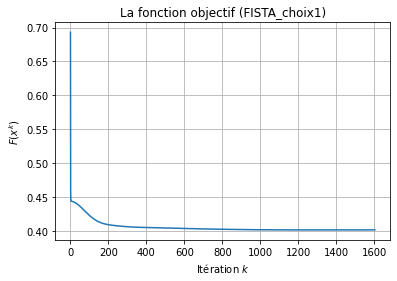

In [125]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(Fk)
plt.xlabel("Itération $k$ ")
plt.ylabel('$F(x^k)$')
plt.title("La fonction objectif (FISTA_choix1)")
plt.grid(True)
plt.show()

On observe, dans un premier temps, une chute rapide de la fonction objective, traduisant une décroissance rapide. Ce comportement reflète l’efficacité initiale de l’algorithme, qui permet de se rapprocher rapidement de la solution optimale.

Ensuite, la diminution devient plus lente à mesure que l’algorithme s’approche du minimum. 

Enfin, la fonction objective devient quasi stationnaire, ce qui indique qu’elle se stabilise autour d’une valeur minimale. Ce phénomène montre que l’algorithme a convergé vers une solution optimale.

In [126]:
K=xn.shape[0]
print(K)

1605


L’algorithme converge en 1605 itérations, conformément au critère d’arrêt imposé.

Une fois l’algorithme FISTA exécuté, la dernière itération est considérée comme une approximation de la solution optimale x* de valeur:

In [127]:
x_star_fista1 = xn[-1] 
x_star_fista1

array([-0.02251324,  0.08230181, -0.00628977, -0.16961332, -0.06636824,
        0.16328028,  0.18487333, -0.73410235])

Par ailleurs, la plus petite valeur de la fonction objectif atteinte au cours des itérations est extraite et constitue une estimation du minimum global de la fonction à minimiser. Et, son valeur:

In [128]:
objective_fista1=min(Fk) #une estimation du minimum global de la fonction à minimiser.
objective_fista1

0.40115586317591106

Enfin, nous représentons graphiquement l’évolution de la norme
$$
\|x^k - x^*\|_2
$$
en fonction du nombre d’itérations, afin de visualiser la convergence des itérés
vers la solution optimale.


In [129]:
distances = np.linalg.norm(xn - x_star_fista1, axis=1)  # norme L2 de chaque xk à x*

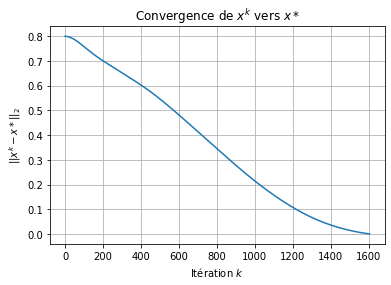

In [130]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(distances)
plt.xlabel("Itération $k$")
plt.ylabel("$||x^k - x*||_2$")
plt.title("Convergence de $x^k$ vers $x*$")
plt.grid(True)
plt.show()


On observe tout d’abord une décroissance monotone de la norme, ce qui indique que les itérés $x^k$ se rapprochent progressivement de la solution optimale $x^*$.

Ensuite, la norme tend vers zéro, ce qui montre que les itérés convergent effectivement vers $x^*$.

Ce graphique met en évidence la bonne convergence de l’algorithme FISTA.


Passons maintenant à l’étude du deuxième choix.
### 3.1.2 Étude du deuxième choix 
Dans le deuxième choix, la fonction $f$  correspond uniquement à la fonction
de perte logistique, identique à la partie $h(x)$ du premier choix.
$$
f(x)=h(x)=\frac{1}{N}\sum_{i=1}^{N}\log\left(1+\exp\left(-b_i x^\top y_i\right)\right).
$$

Les propriétés de la fonction $f$ dans ce deuxième choix sont identiques à
celles de la fonction $h$. En effet, nous avons déjà montré que $h$ est
convexe, propre, semi-continue inférieurement et différentiable. Par conséquent,
la fonction $f$ hérite de ces mêmes propriétés.

De plus, le gradient de $f$ coïncide avec celui de $h$, c’est-à-dire
$$
\nabla f(x) = \nabla h(x)=\frac{1}{N}\,y^\top
\left(
-b_i\frac{\exp\left(-b_i x^\top y_i\right)}{1+\exp\left(-b_i x^\top y_i\right)}
\right)_{1\le i\le N}.
$$
Enfin, comme le gradient de $h$ est Lipschitzien avec une constante de
Lipschitz $L_h$, il en est de même pour le gradient de $f$, avec la même
constante.

Concernant la fonction $g$ du deuxième choix, il s’agit d’une pénalisation Elastic Net, qui combine à la fois une pénalisation de type $\ell_1$ et une pénalisation de type $\ell_2$.

Elle est définie par :
$$
g(x) = \lambda \left( \alpha \|x\|_1 + \frac{1-\alpha}{2}\|x\|_2^2 \right),
$$

Ici, la fonction $g$ correspond à la fonction $q(x)$ du premier choix + le terme de pénalisatiopn de norme 1, qu'on a déjà demontré appartient à $\Gamma_0(\mathbb{R}^d)$.

Comme la norme l1 est non-différentiable et $\alpha$ peut etre différent au zéro donc cela rend le g non différentiable.
                                                                        
### Proximal de la pénalisation Elastic Net($g$):
On a:
$$
g(x) = \lambda \Big( \alpha \|x\|_1 + \frac{1-\alpha}{2} \|x\|_2^2 \Big)
$$

on utilise la formule de perturbation quadratique pour calculer le proximal de $g$.

On décompose $g$ en deux parties :  

$$
g(x) = \underbrace{\lambda \alpha \|x\|_1}_{L1(x)} + \underbrace{\frac{\lambda (1-\alpha)}{2} \|x\|_2^2}_{\text{partie quadratique}}
$$

Le prox d’une somme $L1(x) + \frac{\mu}{2} \|x\|_2^2$ se calcule via :  

$$
\text{prox}_{\gamma (N + \frac{\mu}{2} \|\cdot\|^2)}(v)
= \text{prox}_{\frac{\gamma}{1+\gamma \mu} N} \left( \frac{v}{1+\gamma \mu} \right)
$$

avec $\mu = \lambda (1-\alpha)$.  

L'implementation de proximal de deuxième choix de $g$:

In [131]:
def prox_elastic_net(v, gamma, lam, alpha):
    v_shrink = v / (1 + gamma * lam * (1 - alpha))
    return prox_l1_norm(v_shrink,gamma*lam*alpha*(1/(1 + gamma * lam * (1 - alpha))))


L'implementation de gradient de deuxième choix de $f$:

In [132]:
def grad_f_choix2(x, y, b):
    e_bxTy = np.empty(b.size)
    for i in range(b.size):
        e_bxTy[i] = -b[i] * np.exp(-b[i] * np.dot(x, y[i])) / (1 + np.exp(-b[i] * np.dot(x, y[i])))

    gradf2 = np.dot(y.T, e_bxTy).reshape(x.shape) / b.size

    return gradf2

Nous avons vérifié que les fonctions $f$ et $g$ de deuxième choix satisfont les hypothèses de
l’algorithme FISTA. En particulier, $f$ est différentiable et son gradient est
Lipschitzien, et que $g$ et $f$ appartienent à $\Gamma_0(\mathbb{R}^d)$) . Nous avons également calculé les quantités nécessaires (gradient
de $f$, constante de Lipschitz et opérateur proximal de $g$) afin de pouvoir
appliquer FISTA et implémenter son schéma numérique.

## Implémentation de l’algorithme FISTA (deuxième choix de f et g):

In [133]:
def algo_FISTA2(x0, y, b, gamma, max_iter,alpha,lam, tol):
    
    z0=x0
    t0=1
    x_prev=x0
    z=z0
    t=t0
    xn=[x0]
    for k in tqdm(range(max_iter)):

    # Gradient de f en z
        g2 = grad_f_choix2(z, y, b)

    # Étape proximale 
        x_new = prox_elastic_net(z- gamma*g2, gamma,lam,alpha)

    # Mise à jour du paramètre t
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2

    # Paramètre d'Extrapolation 
        lambda_k = (t - 1) / t_new

    #  Mise à jour du point extrapolé
        z = x_new + lambda_k * (x_new - x_prev)

    #  Sauvegarde de l’itéré courant
        xn.append(x_new)

    # Critère d'arret 
        if np.linalg.norm(x_new - x_prev) < tol:
            break

    # Préparation de l’itération suivante
        x_prev = x_new
        t = t_new
    return np.array(xn)

Le choix des paramètres pour le deuxième choix est identique à celui du premier choix. 
La seule différence réside dans la constante de Lipschitz du gradient de la fonction $f$.

En effet, dans ce deuxième choix, la fonction $f$ correspond uniquement au terme de perte
logistique $h$, sans ajout du terme quadratique de pénalisation. Par conséquent, la constante
de Lipschitz du gradient de $f$ est égale à la constante de Lipschitz du gradient de $h$,
notée $L_h$, qui a déjà été calculée dans l’étude du premier choix.

Alors, le pas de descente est choisi en fonction de cette constante $L_h$, tandis que les autres
paramètres de l’algorithme restent inchangés.


In [134]:
#Paramètres de pénalisation Elastic-net
lam= 1e-3
alpha=0.5

#Constante de Lipschitiz de gradient de f (deuxième choix)
beta = 0.25 * np.linalg.norm(y)**2 / b.size 

#Pas de descente
gamma=0.9/beta

#Tolérance d'arret
tol = 1e-4

#Initialisation
x0 = np.zeros(y.shape[1])

#Nbre d'itérations maximale
max_iter=10000

#Appel d'algorithme FISTA de deuxième choix avec les paramètres choisi
xn2=algo_FISTA2(x0, y, b, gamma, max_iter,alpha,lam, tol)

 16%|█▌        | 1603/10000 [00:02<00:15, 543.18it/s]


Après l’exécution de l’algorithme FISTA de deuxième choix, nous disposons de la suite des itérés
$\{x^k\}_{k=1}^K$, stockée dans la variable xn2.

Nous calculons alors la valeur de la fonction objectif $F(x)$ pour chacun de ces itérés,
afin d’analyser le comportement de convergence de l’algorithme. Plus précisément,
pour chaque itéré $x^k$, nous évaluons :
$$
F(x^k) = f(x^k) + g(x^k),
$$
et les valeurs correspondantes sont stockées dans le vecteur Fk.

Cette étape permet de suivre l’évolution de la fonction objectif au cours des itérations
et de vérifier la décroissance de $F(x^k)$ le long des itérés produits par FISTA de deuxième choix.


In [135]:
Fk = np.array([
    Fctobjective(xk, y, b, lam, alpha)
    for xk in xn2
])


Et voici l’implémentation du graphique représentant l’évolution de la fonction objectif en fonction du nombre d’itérations.


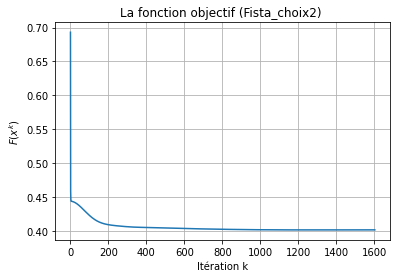

In [136]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(Fk)
plt.xlabel("Itération k")
plt.ylabel('$F(x^k)$')
plt.title("La fonction objectif (Fista_choix2) ")
plt.grid(True)
plt.show()


On observe, dans un premier temps, une chute rapide de la fonction objective, traduisant une décroissance rapide. Ce comportement reflète l’efficacité initiale de l’algorithme, qui permet de se rapprocher rapidement de la solution optimale.

Ensuite, la diminution devient plus lente à mesure que l’algorithme s’approche du minimum. 

Enfin, la fonction objective devient quasi stationnaire, ce qui indique qu’elle se stabilise autour d’une valeur minimale. Ce phénomène montre que l’algorithme a convergé vers une solution optimale.

In [137]:
K2=xn2.shape[0]
print(K2)

1605


L’algorithme(choix 2) converge en 1605 itérations, conformément au critère d’arrêt imposé.

Le premier et le deuxième choix des fonctions $f$ et $g$ présentent des performances
similaires en termes de convergence de l’algorithme FISTA, aussi bien du point de vue
de la vitesse de convergence que du nombre d’itérations(1605) nécessaires pour atteindre la
solution optimale.

Une fois l’algorithme FISTA(choix 2) exécuté, la dernière itération est considérée comme une approximation de la solution optimale x* de valeur:

In [138]:
x_star_fista2=xn2[-1]
x_star_fista2

array([-0.02251324,  0.08230182, -0.00628977, -0.16961332, -0.06636824,
        0.16328028,  0.18487333, -0.73410235])

Par ailleurs, la plus petite valeur de la fonction objectif atteinte au cours des itérations est extraite et constitue une estimation du minimum global de la fonction à minimiser. Et, son valeur:

In [139]:
objective_fista2=min(Fk) #une estimation du minimum global de la fonction à minimiser.
objective_fista2

0.4011558631758711

### Analyse de l’influence du paramètre $\gamma$

 16%|█▌        | 1603/10000 [00:01<00:09, 849.61it/s]


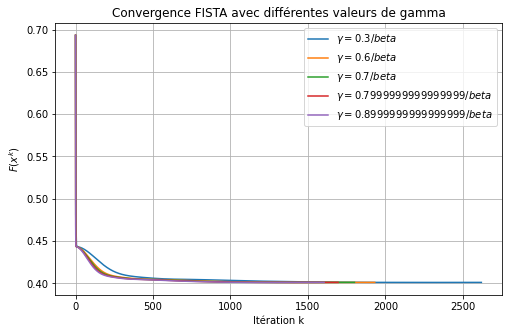

In [140]:
gammas = [0.3/beta, 0.6/beta, 0.7/beta, 0.8/beta,0.9/beta]
plt.figure(figsize=(8,5))

for g in gammas:
    xn2=algo_FISTA2(x0, y, b, g, max_iter,alpha,lam, tol)
    n=xn2.shape[0]
    K=xn2.shape[1]
    Fk = np.array([
        Fctobjective(xk, y, b, lam, alpha)
        for xk in xn2
    ])
    plt.plot(Fk, label=fr'$\gamma = {g*beta}  /beta$')

plt.xlabel("Itération k")
plt.ylabel("$F(x^k)$")
plt.title("Convergence FISTA avec différentes valeurs de gamma")
plt.legend()
plt.grid(True)
plt.show()

À partir du graphique, on observe que l’algorithme FISTA converge pour toutes les valeurs de $\gamma$ testées, ce qui montre la stabilité de la méthode lorsque le pas est choisi conformément à la condition théorique  
$$
\gamma < \frac{1}{\beta}.
$$

On constate cependant que la vitesse de convergence dépend fortement du choix de $\gamma$.  
Pour des valeurs relativement petites de $\gamma$ (par exemple $\gamma = 0.3/\beta$), la décroissance de la fonction objective est plus lente, et un nombre plus élevé d’itérations est nécessaire pour s’approcher du minimum.

En revanche, lorsque $\gamma$ augmente (par exemple $\gamma = 0.7/\beta$, $0.8/\beta$ ou $0.9/\beta$), la convergence devient plus rapide, avec une diminution plus marquée de la fonction objective dès les premières itérations.

Dans tous les cas, les différentes courbes convergent vers la même valeur minimale, ce qui indique que le choix de $\gamma$ n’influence pas la solution finale, mais uniquement la rapidité de convergence de l’algorithme.

Donc,le paramètre $\gamma$ joue donc un rôle clé dans l’efficacité de l’algorithme FISTA :  
un pas plus grand (tout en respectant la condition de stabilité) permet d’accélérer la convergence, tandis qu’un pas trop petit ralentit inutilement l’algorithme.


### 3.2 Algorithme Chambolle-Pock
L’algorithme de Chambolle–Pock est une méthode **primal-duale** destinée à la
résolution de problèmes d’optimisation de la forme :
$$
\min_{x \in X} \; f(Kx) + g(x),
$$
où :
- $X$ et $Y$ sont des espaces vectoriels réels de dimension finie,
- $K : X \to Y$ est un opérateur linéaire borné,
- $f : Y \to [0,+\infty[$ est une fonction convexe, propre et
  semi-continue inférieurement,
- $g : X \to [0,+\infty[$ est une fonction convexe, propre et
  semi-continue inférieurement.

Le problème dual associé s’écrit alors :
$$
\max_{y \in Y} \; -\bigl(g^*(-K^\ast y) + f^*(y)\bigr),
$$
où $f^*$ et $g^*$ désignent les conjuguées de $f$ et $g$, et
$K^\ast$ l’opérateur adjoint de $K$.

Afin de ramener notre problème
$$
\min_{x\in\mathbb{R}^d}
\frac{1}{N}\sum_{i=1}^{N}\log\left(1+\exp\left(-b_i x^\top y_i\right)\right)
+\lambda\left(\alpha\|x\|_1+\frac{1-\alpha}{2}\|x\|_2^2\right)
$$
à la forme standard
$$
\min_{x \in X} \; f(Kx) + g(x).
$$

On considère les espaces
$X = \mathbb{R}^d$ et $Y = \mathbb{R}^N$.
L’opérateur linéaire $K : \mathbb{R}^d \to \mathbb{R}^N$ est défini de telle sorte
que, pour tout $x \in \mathbb{R}^d$, on a
$$
K(x) = \bigl(K_i(x)\bigr)_{i=1,\ldots,N},
\qquad \text{avec} \qquad
K_i(x) = -b_i\, x^\top y_i.
$$
La fonction $f : \mathbb{R}^N \to [0,+\infty[$
$$
f(u)=\frac{1}{N}\sum_{i=1}^{N}\log\left(1+\exp(u_i)\right),
$$
Donc, la fonction $f(Kx)$ s’écrit :
$$
f(Kx) = \frac{1}{N}\sum_{i=1}^{N}
\log\left(1+\exp\left(K_i(x)\right)\right).
$$
Et, la fonction $g: \mathbb{R}^d \to [0,+\infty[$
$$
g(x)=\lambda\left(\alpha\|x\|_1+\frac{1-\alpha}{2}\|x\|_2^2\right).
$$

**Schéma numérique de Chambolle–Pock :**

- Initialiser $x^0 \in \mathbb{R}^d $, $p^0 \in \mathbb{R}^N$, poser $\bar{x}^0 = x^0$.

- Choisir des pas $\tau > 0$, $\sigma > 0$ et un paramètre $\theta \in [0,1]$.

- Pour tout $k \in \mathbb{N}$ :

$$
\begin{aligned}
p^{k+1} &= \operatorname{prox}_{\sigma f^*}\!\left(p^k + \sigma K \bar{x}^k\right), \\
x^{k+1} &= \operatorname{prox}_{\tau g}\!\left(x^k - \tau K^\ast p^{k+1}\right), \\
\bar{x}^{k+1} &= x^{k+1} + \theta\left(x^{k+1} - x^k\right).
\end{aligned}
$$

- Répéter jusqu’à satisfaction du critère d’arrêt.


### Implémentation des opérateurs $K$ et $K^\ast$

Pour implémenter le schéma numérique de Chambolle–Pock, il est nécessaire de
disposer d’une implémentation explicite de l’opérateur linéaire $K$ et de son
adjoint $K^\ast$, car ils interviennent directement dans les mises à jour
primal-duales.
Nous commençons donc par coder $K$, défini dans notre cas par
$$
(Kx)_i=-b_i\,x^\top y_i,\quad i=1,\ldots,N,
$$

In [141]:
def Kf(x, Y, b):
    """
    K(x)_i = -b_i * x^T y_i
    
    x : (d,)
    Y : (N, d)  (ligne i = y_i^T)
    b : (N,)
    return : (N,)
    """
    return -b * (Y @ x)

Afin d’implémenter l’opérateur $K^\ast$, il est nécessaire de déterminer l’expression analytique de l’adjoint de $K$.

Par définition, l’opérateur adjoint $K^\ast : \mathbb{R}^N \to \mathbb{R}^d$
est l’unique opérateur vérifiant
$$
\langle Kx, p \rangle_{\mathbb{R}^N}
=
\langle x, K^\ast p \rangle_{\mathbb{R}^d},
\quad
\forall x \in \mathbb{R}^d,\; \forall p \in \mathbb{R}^N,
$$
où $\langle \cdot,\cdot \rangle$ désigne le produit scalaire euclidien.

Soient donc $x \in \mathbb{R}^d$  et  $p \in \mathbb{R}^N$. On a :
$$
\begin{aligned}
\langle Kx, p \rangle
&= \sum_{i=1}^{N} p_i\, K_i(x) \\
&= \sum_{i=1}^{N} p_i \left(-b_i\, x^\top y_i\right) \\
&= - \sum_{i=1}^{N} p_i b_i\, x^\top y_i\\
&= - x^\top \left( \sum_{i=1}^{N} p_i b_i y_i \right).
\end{aligned}
$$

Par identification avec la définition de l’adjoint, on en déduit que
$$
K^\ast(p) = - \sum_{i=1}^{N} p_i b_i y_i.
$$

En notation matricielle, si l’on note  $Y \in \mathbb{R}^{N \times d}$ la
matrice dont la $i$-ème ligne est $y_i^\top$, cette expression s’écrit :
$$
K^\ast(p) = - Y^\top (b \odot p),
$$
où $\odot$ désigne le produit terme à terme.


In [142]:
def K_adj(p, Y, b):
    """
    K*(p) = - sum_i p_i b_i y_i
    p : (N,)
    return : (d,)
    """
    return -Y.T @ (b * p)


### Implémentation des prox

Nous présentons ci-dessous l’implémentation des opérateurs proximaux
nécessaires à l’algorithme de Chambolle–Pock.
    
#### Calcul et implémentation du proximal de $f^*$
Dans l’algorithme de Chambolle–Pock, la mise à jour nécessite le calcul de
$\operatorname{prox}_{\sigma f^*}$. Nous l’obtenons grâce à l’identité de Moreau :
$$
\operatorname{prox}_{\sigma f^*}(p)=p-\sigma\,\operatorname{prox}_{f/\sigma}\left(\frac{p}{\sigma}\right).
$$
On rappelle que la fonction $f : \mathbb{R}^N \to \mathbb{R}$ est définie par
$$
f(u) = \frac{1}{N}\sum_{i=1}^{N} \log\left(1+\exp(u_i)\right),
\qquad u = (u_1,\ldots,u_N)\in\mathbb{R}^N.
$$

Le calcul de l’opérateur proximal de $f/\sigma$ se fait alors composante par
composante. Plus précisément, pour tout $v \in \mathbb{R}^N$, on a
$$
\operatorname{prox}_{\frac{1}{\sigma} f}(v)
=
\left(
\operatorname{prox}_{\frac{1}{N\sigma}\log(1+\exp(\cdot))}(v_i)
\right)_{i=1,\ldots,N}.
$$
    
Et, pour calculer l’opérateur proximal de la fonction $\log(1+\exp(t))$,
nous avons utilisé une procédure numérique inspirée d’une
implémentation disponible en ligne sur le site [Proximity Operator Repository](https://proximity-operator.net/proximityoperator.html)
.
Cette approche est nécessaire car le proximal de $\log(1+\exp(\cdot))$ ne possède
pas d’expression fermée simple. Le code ci-dessous correspond à cette implémentation.

In [143]:
import numpy as np
from typing import Union

class LogisticLoss:
    def __init__(self):
        pass

    def prox(self, x: np.ndarray, gamma: Union[float, np.ndarray] = 1.0) -> np.ndarray:
        if np.size(x) > 1 and (not isinstance(x, np.ndarray)):
            x = np.array(x)
        if np.size(gamma) > 1 and (not isinstance(gamma, np.ndarray)):
            gamma = np.array(gamma)
        self._check(x, gamma)
        scale = gamma

        x = x / scale
        gamma = 1 / scale

        limit = 8
        w = np.zeros_like(1.0 * x)
        inv_gamma = 1 / gamma
        c = x * inv_gamma - np.log(gamma)
        z = np.exp(c)
        r = np.exp(x * inv_gamma)
        approx = 1 - np.exp((1 - x) * inv_gamma)

        mask = np.logical_and(z > 1, gamma <= 1 / 30)
        w[mask] = c[mask] - np.log(c[mask])
        mask = np.logical_and(z > 1, gamma > 1 / 30)
        if np.size(inv_gamma) > 1:
            inv_gamma = inv_gamma[mask]
        w[mask] = inv_gamma * approx[mask]

        max_iter = 20
        test_end = np.zeros(np.shape(x))
        tol = 1e-8
        epsilon = 1e-20

        for _ in range(max_iter):
            e = np.exp(w)
            y = w * e + r * w - z
            v = e * (1 + w) + r
            u = e * (2 + w)
            w_new = w - y / (v - y * u / (2 * v))
            mask_conv = np.abs(w_new - w) / (epsilon + np.abs(w)) < tol
            test_end[np.logical_and(mask_conv, test_end==0)] = 1
            idx_update = np.logical_and(~mask_conv, test_end==0)
            w[idx_update] = w_new[idx_update]
            if np.sum(test_end) == len(x):
                break

        prox_x = gamma * w
        prox_x = np.array(prox_x, dtype=float)
        prox_x = np.minimum(prox_x, 1)
        return x - scale * prox_x

    def __call__(self, x: np.ndarray) -> float:
        return np.sum(np.log(1 + np.exp(x)))

    def _check(self, x, gamma):
        if np.any(gamma <= 0):
            raise ValueError("gamma must be strictly positive")
        if (np.size(gamma) > 1) and (np.size(gamma) != np.size(x)):
            raise ValueError("gamma must be scalar or same size as x")


L’instruction suivante :

In [144]:
logistic_obj = LogisticLoss()

permet de créer une instance de cette classe, donnant accès à la méthode prox pour calculer le proximal scalaire.

Une fois l’opérateur proximal scalaire de la fonction
$\log(1+\exp(\cdot))$ implémenté, il devient possible de construire le
proximal vectoriel associé à la fonction $f$:
$$
\operatorname{prox}_{\frac{1}{\sigma} f}(v)
=
\left(
\operatorname{prox}_{\frac{1}{N\sigma}\log(1+\exp(\cdot))}(v_i)
\right)_{i=1,\ldots,N}.
$$
Ce calcul est ensuite utilisé, via l’identité de Moreau,
pour obtenir l’opérateur proximal de la fonction conjuguée $f^*$:
$$
\operatorname{prox}_{\sigma f^*}(p)=p-\sigma\,\operatorname{prox}_{f/\sigma}\left(\frac{p}{\sigma}\right).
$$
Alors, le code ci-dessous correspond à l’implémentation de
$\operatorname{prox}_{\sigma f^*}$.


In [145]:
def prox_F_star_vector(p, sigma, b, logistic_obj):
    """
    p : vecteur dual
    sigma : pas dual
    b : labels {+1, -1}
    logistic_obj : instance de LogisticLoss
    """
    N = len(p)
    p_new = np.zeros_like(p)
    
    for i in range(N):
        p_i = p[i] / sigma
        gamma_i = 1 / (N * sigma)
        # appliquer le signe -b_i
        prox_i =  logistic_obj.prox(np.array([p_i]), gamma=gamma_i)[0]
        # prox du dual
        p_new[i] = p[i] - sigma * prox_i
    
    return p_new


Enfin, avant d’implémenter le schéma numérique de Chambolle–Pock, nous avons
besoin de l’opérateur proximal de $g$. Or, ce proximal a déjà été obtenu lors de
l’étude de FISTA (quand la fonction $g$ y correspond au terme de pénalisation
Elastic Net(deuxième choix de g )). Nous réutilisons donc la même implémentation de
$\operatorname{prox}_{\tau g}$ dans l’algorithme de Chambolle–Pock.


## Implémentation de l’algorithme de Chambolle–Pock

Après avoir calculé et implémenté tous les éléments nécessaires au schéma
numérique de l’algorithme de Chambolle–Pock, nous passons maintenant à
l’implémentation complète de ce schéma. À chaque itération $k$, l’algorithme
effectue les étapes suivantes :

- **Mise à jour du dual**
$$
p^{k+1} = \operatorname{prox}_{\sigma f^*}\left(p^k + \sigma K \bar{x}^k\right),
$$

- **Mise à jour du primal**
$$
x^{k+1} = \operatorname{prox}_{\tau g}\left(x^k - \tau K^* p^{k+1}\right),
$$

- **Étape d’extrapolation**
$$
\bar{x}^{k+1} = x^{k+1} + \theta \left(x^{k+1} - x^k\right).
$$

La valeur de la fonction objectif est enregistrée à chaque itération afin de suivre la convergence de l’algorithme.

Le critère d’arrêt est basé sur la condition
$$
\|x^{k+1} - x^k\|_2 < \text{tol}.
$$

La fonction renvoie la solution approchée $x$ ainsi que l’historique des valeurs de la fonction objectif.


In [146]:
def chambolle_pock(y, b, x0, lam, alpha, tau, sigma, max_iter, tol,theta=1.0):

    n, d = y.shape
    logistic_obj = LogisticLoss()
    x = x0.copy()
    x_bar = x.copy()
    p = np.zeros(n)
    history = []
    xnchamb = [] 
    for k in range(max_iter):

        # Mise à jour de dual
        p_new = prox_F_star_vector(p + sigma * Kf(x_bar,y,b), sigma,b,logistic_obj)
        
        # Mise à jour de primal
        x_new = prox_elastic_net(x - tau * K_adj(p_new, y,b), tau, lam, alpha)
        
        xnchamb.append(x_new.copy()) 
        
        # Extrapolation
        x_bar = x_new + theta * (x_new - x)

        # Stocker le valeur de fonction objectif
        history.append(Fctobjective(x_new, y,b, lam, alpha))

        # Critère d'arrêt
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new
        p = p_new

    return x,history,xnchamb

À l’issue de l’exécution, l’algorithme retourne une approximation de la solution
optimale $x$ ainsi que l’historique des valeurs de la fonction objectif.En plus,La variable xnchamb contient l’ensemble des itérés $x^k$ générés par l’algorithme de Chambolle–Pock. À chaque itération, la variable $x^k$ est mise à jour, et sa dernière valeur
correspond à la solution approchée retournée par l’algorithme. 
De plus, la variable `history` stocke les valeurs de la fonction objectif à chaque
itération. Elle permet d’analyser le comportement de convergence de la méthode
et de tracer l’évolution de la fonction de coût en fonction du nombre
d’itérations.

## Choix des paramètres pour l’algorithme de Chambolle–Pock

Nous passons maintenant au choix des paramètres de l’algorithme de
Chambolle–Pock. Les pas $\tau$ et $\sigma$ sont choisis de manière à satisfaire
la condition de convergence de l’algorithme :
$$
\tau\,\sigma\,\|K\|^2 < 1.
$$

Nous fixons un facteur $c = 0{,}9$ et choisissons
$$
\tau = \frac{0{,}9}{\beta}, \qquad
\sigma = \frac{0{,}9}{\tau \|K\|^2},
$$
où $\beta$ désigne la constante de Lipschitz du gradient de la fonction $f$.
Ce choix garantit que
$$
\tau\,\sigma\,\|K\|^2 = 0{,}9 < 1,
$$
et assure ainsi la convergence théorique de l’algorithme.

Pour calculer le paramètre $\sigma$, il est nécessaire d’évaluer la norme de l’opérateur linéaire $K$. Dans notre problème, l’opérateur $K : \mathbb{R}^d \to \mathbb{R}^N$ est défini
composante par composante par
$$
(Kx)_i = -b_i \langle x, y_i \rangle, \quad i = 1,\dots,N.
$$

En écriture matricielle, on peut écrire
$$
K = -\operatorname{diag}(b)\, Y,
$$
où $Y \in \mathbb{R}^{N \times d}$ est la matrice dont la $i$-ème ligne est
$y_i^\top$.

Comme la matrice diagonale $\operatorname{diag}(b)$ contient uniquement des
coefficients $\pm 1$, elle ne modifie pas la norme opérateur. Ainsi, la norme de
$K$ est équivalente à celle de $Y$, et l’on peut approximer
$$
\|K\| \simeq \|Y\|.
$$

L’algorithme est ensuite exécuté à partir d’une initialisation nulle $x^0 = (0,...,0) \in \mathbb{R}^d$,
avec un nombre maximal d’itérations fixé à $10\,000$ et une tolérance
$\text{tol} = 10^{-8}$.

Le paramètre $\lambda > 0$ contrôle l’intensité globale de la régularisation,
tandis que $\alpha \in [0,1]$ permet d’ajuster le compromis entre la pénalisation
$\ell_1$ et la pénalisation $\ell_2$. Et dans nos expériences numériques, nous avons fixé ces paramètres à
$$
\lambda = 10^{-3} \quad \text{et} \quad \alpha = 0{,}6.
$$

In [147]:
tau = 0.9 / beta
K_norm2 = np.linalg.norm(y, ord=2)**2
sigma = 0.9 / (tau * K_norm2)
max_iter=10000
tol=1e-8
lam= 1e-3
alpha=0.5
x0 = np.zeros(y.shape[1])

Une fois les paramètres de l’algorithme fixés, nous exécutons l’algorithme de
Chambolle–Pock via l’appel suivant. Celui-ci retourne une approximation de la
solution optimale, notée x_star_CP, ainsi que l’historique des valeurs de la
fonction objectif, stocké dans history et la variable xnchamb qui contient l’ensemble des itérés primaux $x^k$ générés par
l’algorithme de Chambolle–Pock. 


In [148]:
x_star_CP, history, xnchamb = chambolle_pock(y, b, x0, lam, alpha, tau, sigma, max_iter, tol,theta=1)

Afin d’analyser la convergence de l’algorithme de Chambolle–Pock, nous traçons
l’évolution de la fonction objectif $F(x^k)$ en fonction du nombre
d’itérations.

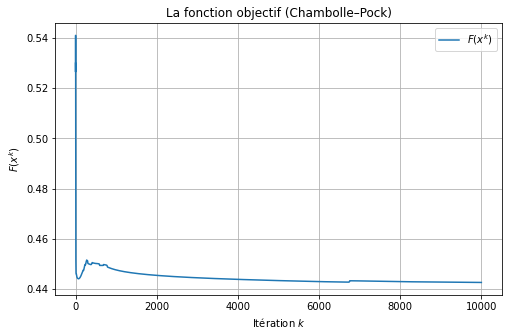

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history, label='$F(x^k)$')
plt.xlabel("Itération $k$")
plt.ylabel("$F(x^k)$")
plt.title("La fonction objectif (Chambolle–Pock)")
plt.grid(True)
plt.legend()
plt.show()

Le graphe montre une décroissance monotone de la fonction objectif $F(x^k)$, avec une convergence progressive vers une valeur stable, confirmant la bonne convergence de l’algorithme de Chambolle–Pock pour les paramètres choisis.

La valeur minimale atteinte par la fonction objectif est donnée par :

In [150]:
min(history)

0.44272234058015075

La valeur finale $F(x^{k_{\max}})$:

In [151]:
history[-1]

0.44272234058015075

Le fait que la valeur minimale de la fonction objectif coïncide avec sa valeur à la dernière itération signifie que l’algorithme a atteint un point stationnaire, ce qui confirme la convergence de l’algorithme.

Enfin, nous représentons graphiquement l’évolution de la norme
$$
\|x^k - x^*\|_2
$$
en fonction du nombre d’itérations, afin de visualiser la convergence des itérés
vers la solution optimale.


In [153]:
distances_CP = np.linalg.norm(np.array(xnchamb) - x_star_CP, axis=1)

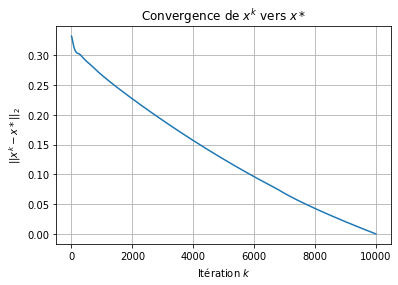

In [154]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(distances_CP)
plt.xlabel("Itération $k$")
plt.ylabel("$||x^k - x*||_2$")
plt.title("Convergence de $x^k$ vers $x*$")
plt.grid(True)
plt.show()

On observe tout d’abord une décroissance monotone de la norme, ce qui indique que les itérés $x^k$ se rapprochent progressivement de la solution optimale 
$x^*$ au fil des itérations. Cette décroissance traduit le bon comportement de convergence de l’algorithme.
Enfin, la norme tend vers zéro lorsque $k$ augmente, ce qui montre que
$$
x^k \longrightarrow x^*,
$$
et confirme la convergence effective de l’algorithme vers la solution optimale.



Ici, nous utilisons la même procédure que celle de Chambolle–Pock de la partie avant ; cependant, le prox du logarithme n’a pas été obtenu à partir de sources en ligne, mais calculé de façon numérique approchée.

In [155]:
def Kf(x, Y):
    """Opérateur linéaire K(x) = Yx"""
    return Y @ x

def K_adj(p, Y):
    """Adjoint de K : K*(p) = Y^T p"""
    return Y.T @ p


In [156]:
def prox_F_star(p, sigma, b, n_iter=100):
    u = p / sigma  # initialisation
    N=200
    for _ in range(n_iter):
        exp_term = np.exp(-b * u)
        grad = -b * exp_term / (1 + exp_term) + sigma * (u - p/sigma)
        hess = exp_term / (1 + exp_term)**2 + sigma
        u -= grad / hess

    return p - sigma * u


In [157]:
def prox_F_star_vector(p, sigma, b):
    """
    p : vecteur dual (taille N)
    sigma : pas dual
    b : vecteur labels {-1,1} (taille N)
    """
    N = len(p)
    sigma_i = sigma / N  # correction pour la moyenne 1/N
    return np.array([prox_F_star(p[i], sigma_i, b[i]) for i in range(N)])



In [161]:
def chambolle_pock_self(y, b, x0, lam, alpha, tau, sigma, max_iter, tol,theta=1.0):

    n, d = y.shape
    x = x0.copy()
    x_bar = x.copy()
    p = np.zeros(n)
    history_s = []
    for k in range(max_iter):

        # Dual update 
        p_new = prox_F_star_vector(p + sigma * Kf(x_bar, y), sigma, b)

        # Primal update
        x_new = prox_elastic_net(x - tau * K_adj(p_new, y), tau, lam, alpha)

        # Extrapolation
        x_bar = x_new + theta * (x_new - x)

        # Stocker la  valeur de fonction objectif 
        history_s.append(Fctobjective(x_new, y, b, lam, alpha))

        # Critère d'arrêt 
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new
        p = p_new

    return x,history_s


In [162]:
tau = 0.9 / beta
sigma = 0.9 / (tau * K_norm2)
max_iter=10000
tol=1e-8
lam= 1e-3
alpha=0.5
x0 = np.zeros(y.shape[1])

In [163]:
xnchamb_s,history_s=chambolle_pock_self(y, b, x0, lam, alpha, tau, sigma, max_iter, tol,theta=1.0)

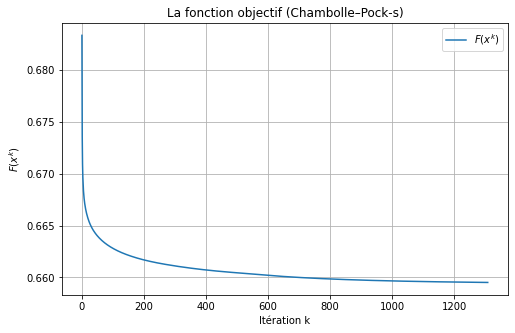

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history_s, label='$F(x^k)$')
plt.xlabel("Itération k")
plt.ylabel("$F(x^k)$")
plt.title("La fonction objectif (Chambolle–Pock-s)")
plt.grid(True)
plt.legend()
plt.show()

### 3.3 Algorithme ADAM

Afin d’utiliser l’algorithme ADAM, implémenté dans la bibliothèque *PyTorch*,
nous commençons par convertir les données depuis le format *NumPy* vers des
tenseurs *PyTorch*.


In [165]:
import torch

# Conversion de numpy vers torch
Y_t = torch.tensor(y, dtype=torch.float32)
b_t = torch.tensor(b, dtype=torch.float32)

N, d = Y_t.shape

Le vecteur de paramètres est initialisé à zéro .

In [166]:
x = torch.zeros(d, requires_grad=True)

Nous définissons ensuite la fonction objectif correspondant à la régression
logistique régularisée par Elastic Net.

In [167]:
def objective(x, Y, b, lam, alpha):
    # Log-loss moyenne
    z = b * (Y @ x)
    loss = torch.mean(torch.log1p(torch.exp(-z)))

    # Elastic Net
    l1 = lam * alpha * torch.norm(x, p=1)
    l2 = 0.5 * lam * (1 - alpha) * torch.sum(x**2)

    return loss + l1 + l2


Pour minimiser la fonction objectif définie précédemment, nous utilisons
l’algorithme **Adam**, disponible dans la bibliothèque **PyTorch** via le module
`torch.optim.Adam`, avec un taux d’apprentissage choisi égal à
$\mathrm{lr} = 10^{-3}$, ce qui détermine l’amplitude des mises à jour des
paramètres.



In [168]:
optimizer = torch.optim.Adam([x], lr=1e-3)

Nous fixons le nombre maximal d’itérations, les paramètres de régularisation
et initialisons une liste destinée à stocker l’évolution de la fonction
objectif.


In [169]:
max_iter = 500
lam= 1e-3
alpha=0.5
F_vals = []

À chaque itération, l’algorithme effectue les étapes suivantes :

1. Les gradients accumulés de l’itération précédente sont réinitialisés à l’aide
   de la commande `optimizer.zero_grad()`.

2. La valeur courante de la fonction objectif est ensuite calculée à partir des
   paramètres actuels $x$.

3. Le gradient de la fonction objectif par rapport à $x$ est automatiquement
   calculé par différentiation automatique via la commande `loss.backward()`.

4. Les paramètres sont mis à jour à l’aide de la règle de mise à jour propre à
   l’optimiseur ADAM, grâce à l’appel `optimizer.step()`.

5. La valeur de la fonction objectif est stockée dans la liste `F_vals` afin de
   suivre l’évolution de la convergence au cours des itérations.

6. Un critère d’arrêt est enfin appliqué.

À l’issue de l’algorithme, le vecteur $x$ obtenu correspond à une approximation
de la solution optimale, et la liste `F_vals` permet d’analyser le comportement
de convergence de la méthode.

Le code suivant met en œuvre ces différentes étapes et constitue
l’implémentation numérique de l’algorithme ADAM.


In [170]:
for k in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    loss = objective(x, Y_t, b_t, lam, alpha)
    loss.backward()
    
    optimizer.step()
    
    F_vals.append(loss.item())

    if k > 0 and torch.norm(x - x_prev) < tol:
        break

    x_prev = x.detach().clone()
x_adam = x.detach().numpy()
    

100%|██████████| 500/500 [00:00<00:00, 1124.49it/s]


Nous passons maintenant à l’implémentation de l'évolution de la fonction objectif en
fonction du nombre d’itérations.

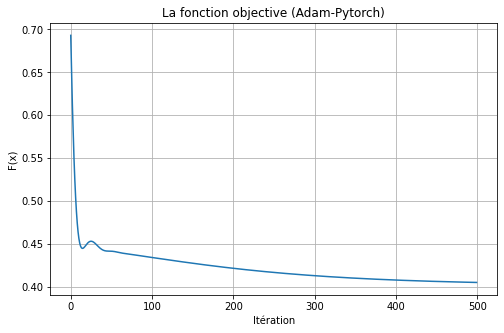

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(F_vals)
plt.xlabel("Itération")
plt.ylabel("F(x)")
plt.title("La fonction objective (Adam-Pytorch)")
plt.grid(True)
plt.show()


La figure ci-dessus illustre l’évolution de la valeur de la fonction objectif
au cours des itérations de l’algorithme ADAM.

On observe une décroissance rapide de la fonction objectif durant les premières
itérations, ce qui traduit une convergence rapide initiale de l’algorithme.
Par la suite, la diminution devient plus progressive, indiquant que les
paramètres se stabilisent autour d’un minimum.

Ce comportement est caractéristique de l’algorithme ADAM, qui combine une phase
d’optimisation rapide au début grâce à l’adaptation automatique du pas de
gradient, suivie d’un affinement progressif de la solution. La convergence
numérique observée confirme la capacité de l’algorithme à minimiser efficacement
la fonction objectif considérée.


### 4. Comparaison entre les algorithmes

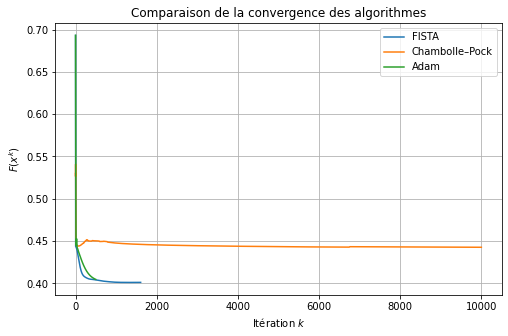

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(Fk, label="FISTA")
plt.plot(history, label="Chambolle–Pock")
plt.plot(F_vals, label="Adam")

plt.xlabel("Itération $k$")
plt.ylabel("$F(x^k)$")
plt.title("Comparaison de la convergence des algorithmes")
plt.legend()
plt.grid(True)

plt.show()


Adam converge le plus rapidement parmi les algorithmes considérés, suivi de FISTA, qui présente également une convergence rapide grâce à son mécanisme d’accélération.
En revanche, Chambolle–Pock converge plus lentement et nécessite un nombre plus élevé d’itérations pour atteindre la stabilité.

Malgré ces différences de vitesse de convergence, les trois algorithmes atteignent des valeurs finales comparables de la fonction objectif, ce qui indique qu’ils fournissent tous une approximation satisfaisante de la solution optimale.

In [173]:
def predict(x, y):
    scores = y @ x
    return np.where(scores >= 0, 1, -1)


In [174]:
def accuracy(x, y, b):
    y_pred = predict(x, y)
    return np.mean(y_pred == b)


In [175]:
def log_loss(x, y, b):
    z = b * (y @ x)
    return np.mean(np.log(1 + np.exp(-z)))


In [176]:
x = torch.zeros(y.shape[1], requires_grad=True)

optimizer = torch.optim.Adam([x], lr=1e-2)

for k in range(max_iter):
    optimizer.zero_grad()

    F = objective(x, Y_t, b_t, lam, alpha)
    F.backward()
    optimizer.step()

    if k > 0 and torch.norm(x - x_prev) < tol:
        break

    x_prev = x.detach().clone()

x_adam = x.detach().numpy()

In [177]:
print("F(x_adam) =", Fctobjective(x_adam,y,b,lam,alpha))


F(x_adam) = 0.4011754725268245


In [178]:
x_star_fista1

array([-0.02251324,  0.08230181, -0.00628977, -0.16961332, -0.06636824,
        0.16328028,  0.18487333, -0.73410235])

In [179]:
x_chams=xnchamb_s

In [180]:
results = {
    "FISTA": {
        "accuracy": accuracy(x_star_fista1, y, b),
        "logloss": log_loss(x_star_fista1, y, b),
        
    },
    "ADAM": {
        "accuracy": accuracy(x_adam, y, b),
        "logloss": log_loss(x_adam, y, b),
        
    },
    "Chambolle-Pock-s": {
        "accuracy": accuracy(x_chams, y, b),
        "logloss": log_loss(x_chams, y, b),
        
    },
    "Chambolle-Pock": {
        "accuracy": accuracy(x_star_CP, y, b),
        "logloss": log_loss(x_star_CP, y, b),
    }
}

results

{'FISTA': {'accuracy': 0.855, 'logloss': 0.40035938711704944},
 'ADAM': {'accuracy': 0.86, 'logloss': 0.4003738074740531},
 'Chambolle-Pock-s': {'accuracy': 0.855, 'logloss': 0.6595141972691815},
 'Chambolle-Pock': {'accuracy': 0.855, 'logloss': 0.4424143386454407}}

In [181]:
from sklearn.model_selection import train_test_split

y_train, y_test, b_train, b_test = train_test_split(
    y, b, test_size=0.3, random_state=0
)


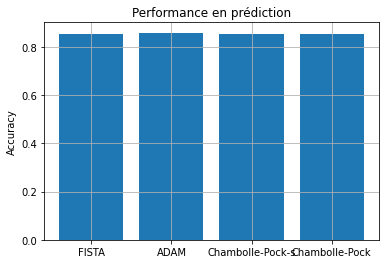

In [182]:
import matplotlib.pyplot as plt

names = list(results.keys())
accs = [results[n]["accuracy"] for n in names]

plt.bar(names, accs)
plt.ylabel("Accuracy")
plt.title("Performance en prédiction")
plt.grid(True)
plt.show()
